# Quiz 3 Notes

## Table of Contents
1. [Linear Regression](#linearReg)
2. [Clustering](#cluster)
3. [Inference I](#inf1)
4. [Inference II](#inf2)


## Linear Regression <a name="linearReg"></a>
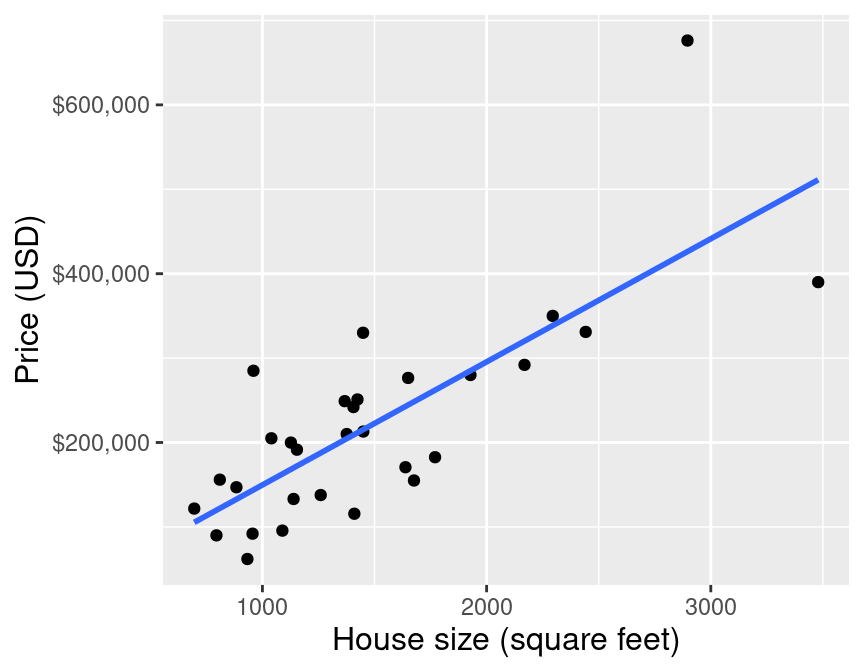

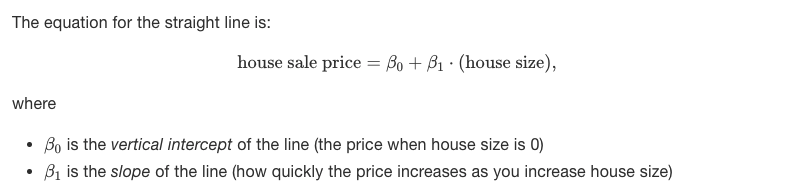

choosing the line that minimizes the **average squared vertical distance** between itself and each of the observed data points in the training data. 

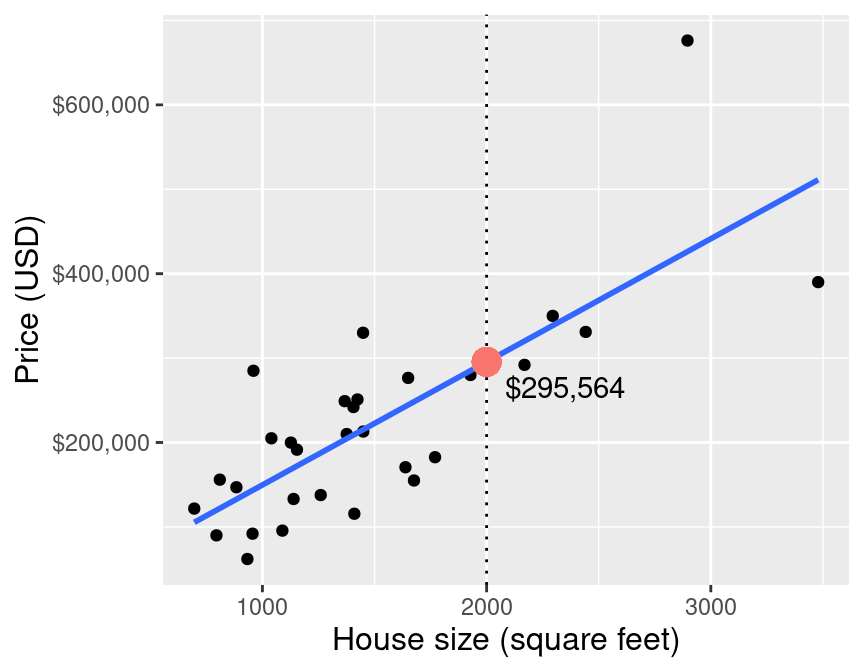

we do not need to choose K in the context of linear regression, and so we do not need to perform cross-validation. 

In [ ]:
library(tidyverse)
library(tidymodels)

set.seed(1234)

sacramento <- read_csv("data/sacramento.csv")

# splitting data
sacramento_split <- initial_split(sacramento, prop = 0.6, strata = price)
sacramento_train <- training(sacramento_split)
sacramento_test <- testing(sacramento_split)


# model specification
lm_spec <- linear_reg() %>%
  set_engine("lm") %>%
  set_mode("regression")

lm_recipe <- recipe(price ~ sqft, data = sacramento_train)

lm_fit <- workflow() %>%
  add_recipe(lm_recipe) %>%
  add_model(lm_spec) %>%
  fit(data = sacramento_train)

lm_fit

In linear regression, standardization does not affect the fit (it does affect the coefficients in the equation, though!)

In [ ]:
# predict testing set with trained linear regression model
lm_test_results <- lm_fit %>%
  predict(sacramento_test) %>%
  bind_cols(sacramento_test) %>%
  metrics(truth = price, estimate = .pred)

lm_test_results

In [ ]:
# plotting data
lm_plot_final <- ggplot(sacramento_train, aes(x = sqft, y = price)) +
  geom_point(alpha = 0.4) +
  xlab("House size (square feet)") +
  ylab("Price (USD)") +
  scale_y_continuous(labels = dollar_format()) +
  geom_smooth(method = "lm", se = FALSE) + 
  theme(text = element_text(size = 12))

lm_plot_final

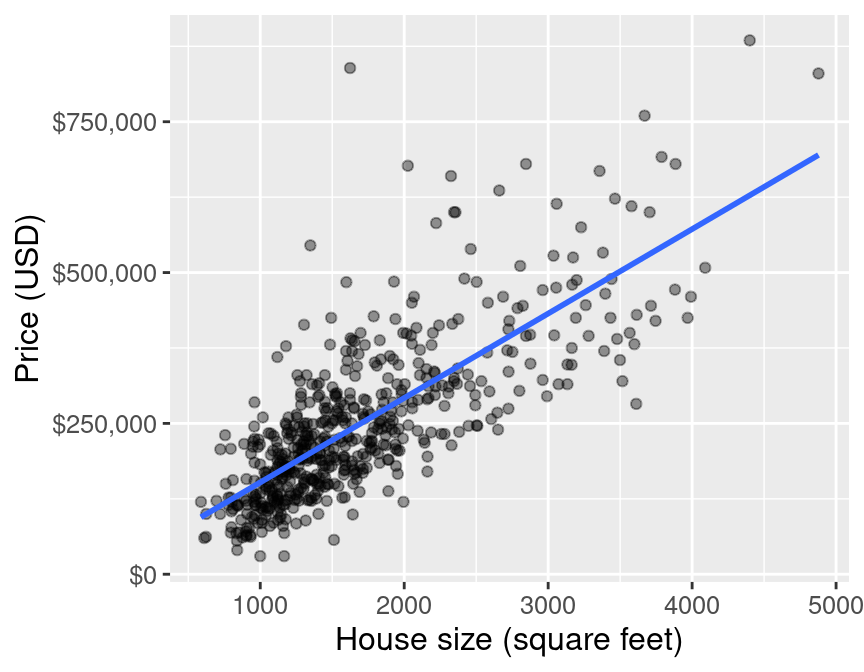

In [ ]:
# exxtract coefficient
coeffs <- lm_fit %>%
             pull_workflow_fit() %>% # extract it from the workflow
             tidy() # convert the result into a data frame

coeffs

### Linear Reg vs. KNN
1. A straight line can be defined by two numbers, the vertical intercept and the slope. The intercept tells us what the prediction is when all of the predictors are equal to 0; and the slope tells us what unit increase in the target/response variable we predict given a unit increase in the predictor variable. KNN regression, as simple as it is to implement and understand, has no such **interpretability** from its wiggly line.
2. when the relationship between the target and the predictor is **not linear**, but instead some other shape (e.g., curved or oscillating) --> prediction model from a simple linear regression will underfit (have high bias)
3. **Extrapolation**: note that the KNN regression model becomes “flat” at the left and right boundaries of the data, while the linear model predicts a constant slope. Predicting outside the range of the observed data 

## Multivariable linear regression


In [ ]:
mlm_recipe <- recipe(price ~ sqft + beds, data = sacramento_train)

mlm_fit <- workflow() |>
  add_recipe(mlm_recipe) |>
  add_model(lm_spec) |>
  fit(data = sacramento_train)

mlm_fit

lm_mult_test_results <- mlm_fit |>
  predict(sacramento_test) |>
  bind_cols(sacramento_test) |>
  metrics(truth = price, estimate = .pred)

lm_mult_test_results

#extract those slope values from our model object
mcoeffs <- mlm_fit |>
             pull_workflow_fit() |>
             tidy()

mcoeffs

**Outliners**: can have too much influence on the line of best fit. Fortunately, if you have enough data, the inclusion of one or two outliers—as long as their values are not too wild—will typically not have a large effect on the line of best fit.
**Multicollinearity**:  multiple predictors that are strongly linearly related to one another, the coefficients that describe the plane of best fit can be very unreliable—small changes to the data can result in large changes in the coefficients. -->  avoid including very linearly related predictors

## Clustering <a name = "cluster"> <a/>

data analysis task involving separating a data set into subgroups of related data. For example, we might use clustering to separate a data set of documents into groups that correspond to topics, a data set of human genetic information into groups that correspond to ancestral subpopulations, or a data set of online customers into groups that correspond to purchasing behaviors. use the subgroups to generate new questions about the data and follow up with a predictive modeling exercise. In this course, clustering will be used only for exploratory analysis, i.e., uncovering patterns in the data.

### Clustering vs. Classification and Regression
- classification and regression are supervised tasks where there is a response variable (a category label or value), and we have examples of past data with labels/values that help us predict those of future data
- clustering is an unsupervised task, as we are trying to understand and examine the structure of data without any response variable labels or values to help us. 


### Clustering and Visualization
 
 

In [ ]:
library(tidyverse)
set.seed(1) # important --> K-means clustering algorithm uses random numbers.

penguin_data <- read_csv("data/penguins_standardized.csv")
ggplot(data, aes(x = flipper_length_standardized, 
                 y = bill_length_standardized)) +
  geom_point() +
  xlab("Flipper Length (standardized)") +
  ylab("Bill Length (standardized)") + 
  theme(text = element_text(size = 12))

### Measuring Cluster Quality
**within-cluster sum-of-squared-distances (WSSD)**
1. find the cluster centers by computing the mean of each variable over data points in the cluster
2. add up the squared distance between each point in the cluster and the cluster center
3. After we have calculated the WSSD for all the clusters, we sum them together to get the total WSSD

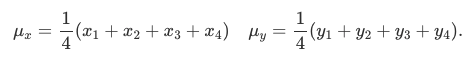
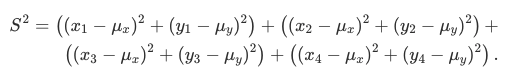
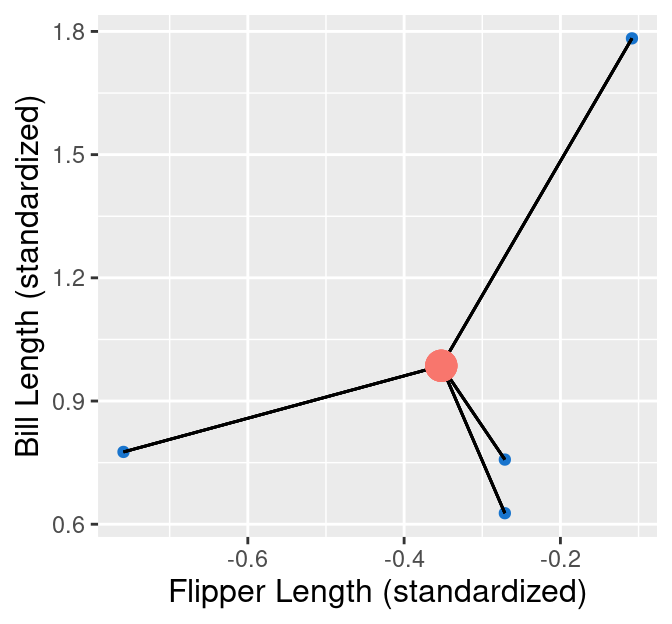

The larger the value of  S^2, the more spread out the cluster is

### K-means algorithm

We begin the K-means algorithm by picking K, and randomly assigning a roughly equal number of observations to each of the K clusters.
1. Center update: Compute the center of each cluster.
2. Label update: Reassign each data point to the cluster with the nearest center.

These two steps are repeated until the cluster assignments no longer change.

**Random restarts**
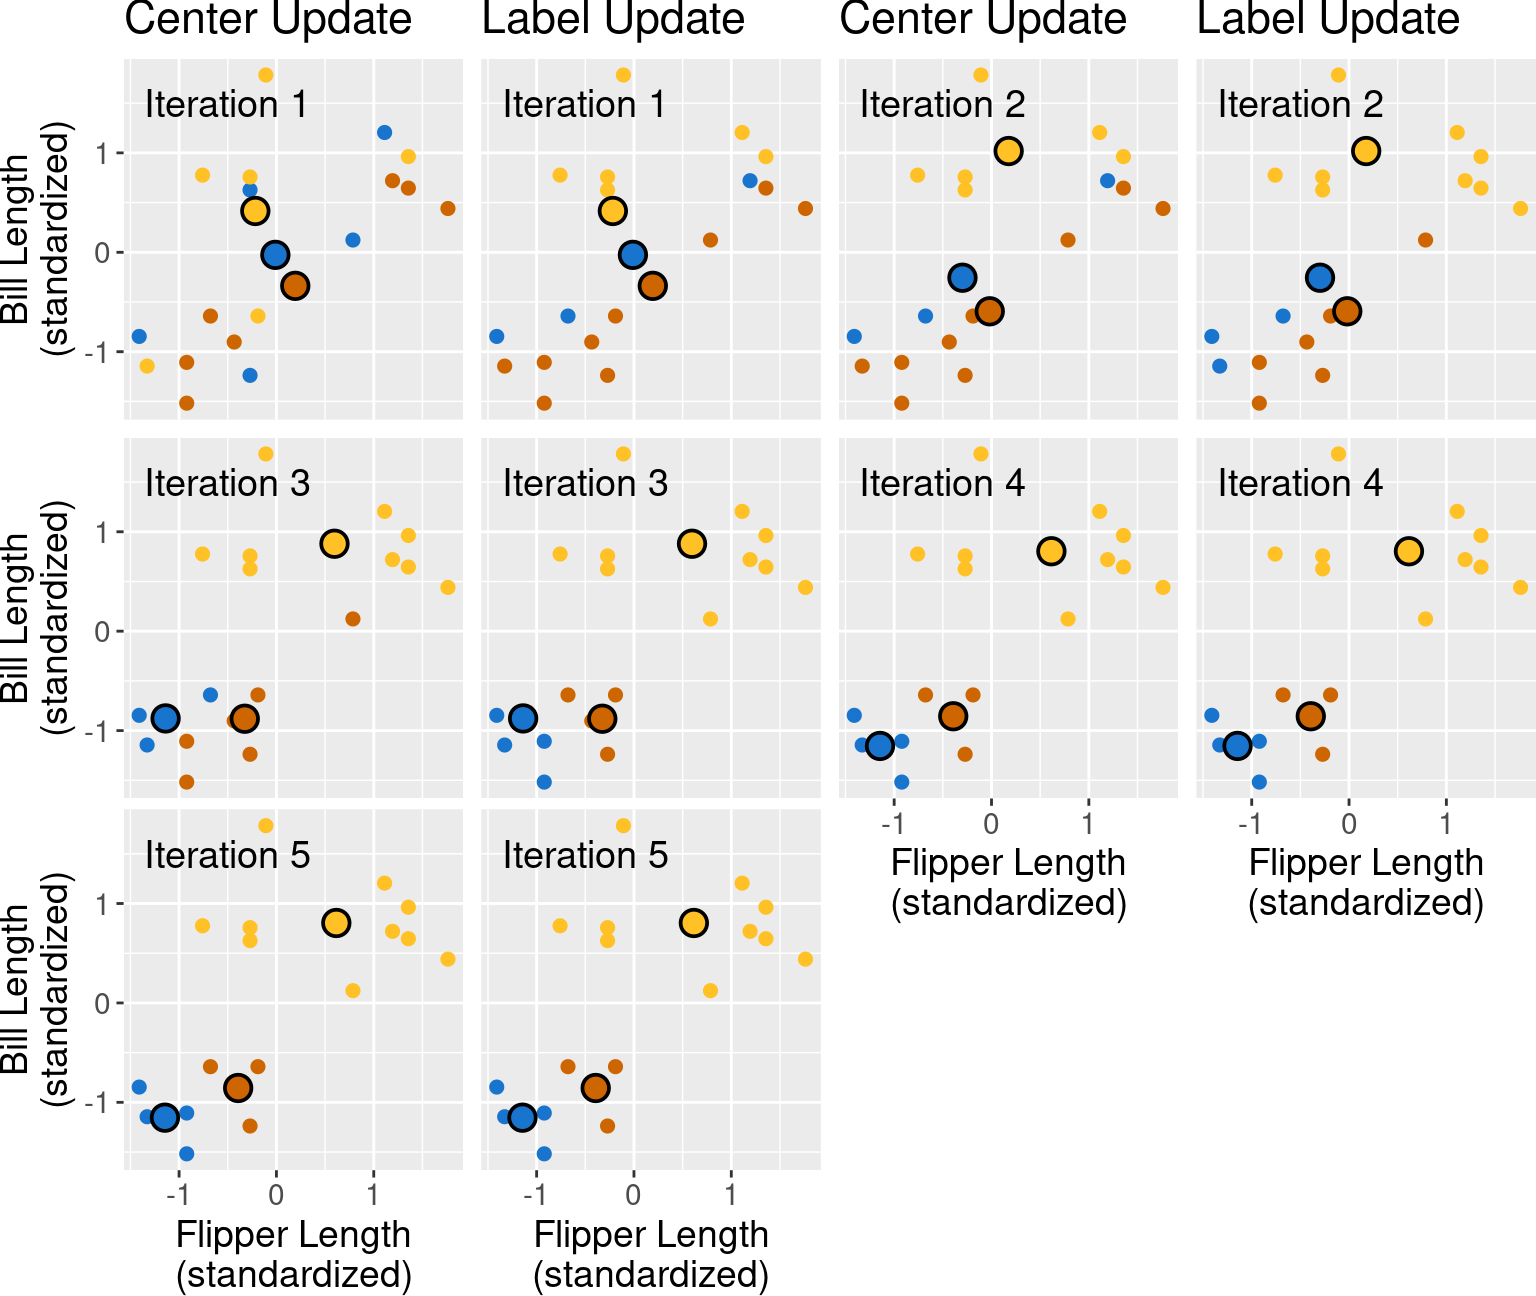
To solve this problem when clustering data using K-means, we should randomly re-initialize the labels a few times, run K-means for each initialization, and pick the clustering that has the lowest final total WSSD.

### Choosing K
If K is chosen too small, then multiple clusters get grouped together; if K is too large, then clusters get subdivided. In both cases, we will potentially miss interesting structure in the data.

If we set K less than 3, then the clustering merges separate groups of data; this causes a large total WSSD, since the cluster center (denoted by an “x”) is not close to any of the data in the cluster. On the other hand, if we set K greater than 3, the clustering subdivides subgroups of data; this does indeed still decrease the total WSSD, but by only a diminishing amount.

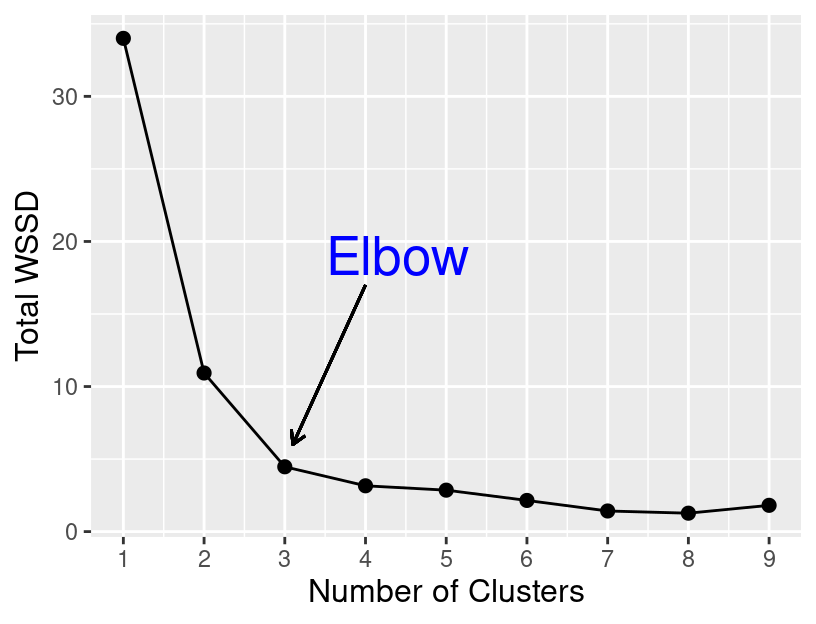

 If we plot the total WSSD versus the number of clusters, we see that the decrease in total WSSD levels off (or forms an “elbow shape”) when we reach roughly the right number of clusters 


### Data Pre-processing
Variables with a large scale will have a much larger effect on deciding cluster assignment than variables with a small scale. 


In [ ]:
not_standardized_data <- read_csv("data/penguins_not_standardized.csv")

# apply the scale function to every column in the data frame using mutate + across
standardized_data <- not_standardized_data %>%
  mutate(across(everything(), scale))

# K-means - uses a random initialization of assignments, but since we set the random seed earlier, the clustering will be reproducible.
penguin_clust <- kmeans(standardized_data, centers = 3)

library(broom)
# returns a data frame with the data and the cluster assignments for each point
clustered_data <- augment(penguin_clust, standardized_data)
clustered_data

# plot cluster assignments
cluster_plot <- ggplot(clustered_data,
  aes(x = flipper_length_mm, 
      y = bill_length_mm, 
      color = .cluster), 
  size = 2) +
  geom_point() +
  labs(x = "Flipper Length (standardized)", 
       y = "Bill Length (standardized)", 
       color = "Cluster") + 
  scale_color_manual(values = c("dodgerblue3",
                                "darkorange3",  
                                "goldenrod1")) + 
  theme(text = element_text(size = 12))

cluster_plot

# obtain total WSSD (tot.withinss) from our clustering using broom’s glance function
glance(penguin_clust)

# Tuning for K
penguin_clust_ks <- tibble(k = 1:9) %>%
  rowwise() %>%
  mutate(penguin_clusts = list(kmeans(standardized_data, k)))

# get one of the clusterings out of the list column in the data frame
penguin_clust_ks  %>%
  pull(penguin_clusts)  %>% # pull the list
  pluck(1) # get first item in the list

# use mutate again to apply glance to each of the K-means clustering objects to get the clustering statistics (including WSSD)
penguin_clust_ks <- tibble(k = 1:9)  %>%
  rowwise()  %>%
  mutate(penguin_clusts = list(kmeans(standardized_data, k)),
         glanced = list(glance(penguin_clusts))) # added glanced function here

penguin_clust_ks

### Tuning for K -> can skip to next step for full algo with multiple starting points to avoid bad clustering

In [ ]:
# optional if using the next code box

# Tuning for K
penguin_clust_ks <- tibble(k = 1:9) %>%
  rowwise() %>%
  mutate(penguin_clusts = list(kmeans(standardized_data, k)))

# get one of the clusterings out of the list column in the data frame
penguin_clust_ks  %>%
  pull(penguin_clusts)  %>% # pull the list
  pluck(1) # get first item in the list



In [ ]:
# use mutate again to apply glance to each of the K-means clustering objects to get the clustering statistics (including WSSD)
penguin_clust_ks <- tibble(k = 1:9)  %>%
  rowwise()  %>%
  mutate(penguin_clusts = list(kmeans(standardized_data, k)),
         glanced = list(glance(penguin_clusts))) # added glanced function here

penguin_clust_ks

# extract the total WSSD from the column named glanced
clustering_statistics <- penguin_clust_ks |>
  unnest(glanced) # unpack the data frames into simpler column data types

clustering_statistics

In [ ]:
# plotting K values
elbow_plot <- ggplot(clustering_statistics, aes(x = k, y = tot.withinss)) +
  geom_point() +
  geom_line() +
  xlab("K") +
  ylab("Total within-cluster sum of squares") +
  scale_x_continuous(breaks = 1:9) + 
  theme(text = element_text(size = 12))

elbow_plot

### Avoiding bad clustering

prevent finding a bad clustering by trying a few different random initializations via the nstart argument   
K-means clustering will be performed the number of times specified by the nstart argument, and R will return to us the best clustering from this  
The larger the nstart value the better from an analysis perspective, but there is a trade-off that doing many clusterings could take a long time.

In [ ]:
penguin_clust_ks <- tibble(k = 1:9) |>
  rowwise() |>
  mutate(penguin_clusts = list(kmeans(standardized_data, nstart = 10, k)), # nstart added here
         glanced = list(glance(penguin_clusts)))

clustering_statistics <- penguin_clust_ks |>
  unnest(glanced)

elbow_plot <- ggplot(clustering_statistics, aes(x = k, y = tot.withinss)) +
  geom_point() +
  geom_line() +
  xlab("K") +
  ylab("Total within-cluster sum of squares") +
  scale_x_continuous(breaks = 1:9) + 
  theme(text = element_text(size = 12))

elbow_plot

## Inference I <a name = "inf1"><a/>
    
Data analysis questions regarding how summaries, patterns, trends, or relationships in a data set extend to the wider population are called **inferential questions**.
- two common techniques in statistical inference: *point estimation* and *interval estimation*.
    

### Sampling
population, population parameter  
sample, sample estimate - a numerical characteristic of the sample—that estimates the population parameter

the process of using a sample to make a conclusion about the broader population from which it is taken is referred to as **statistical inference**.

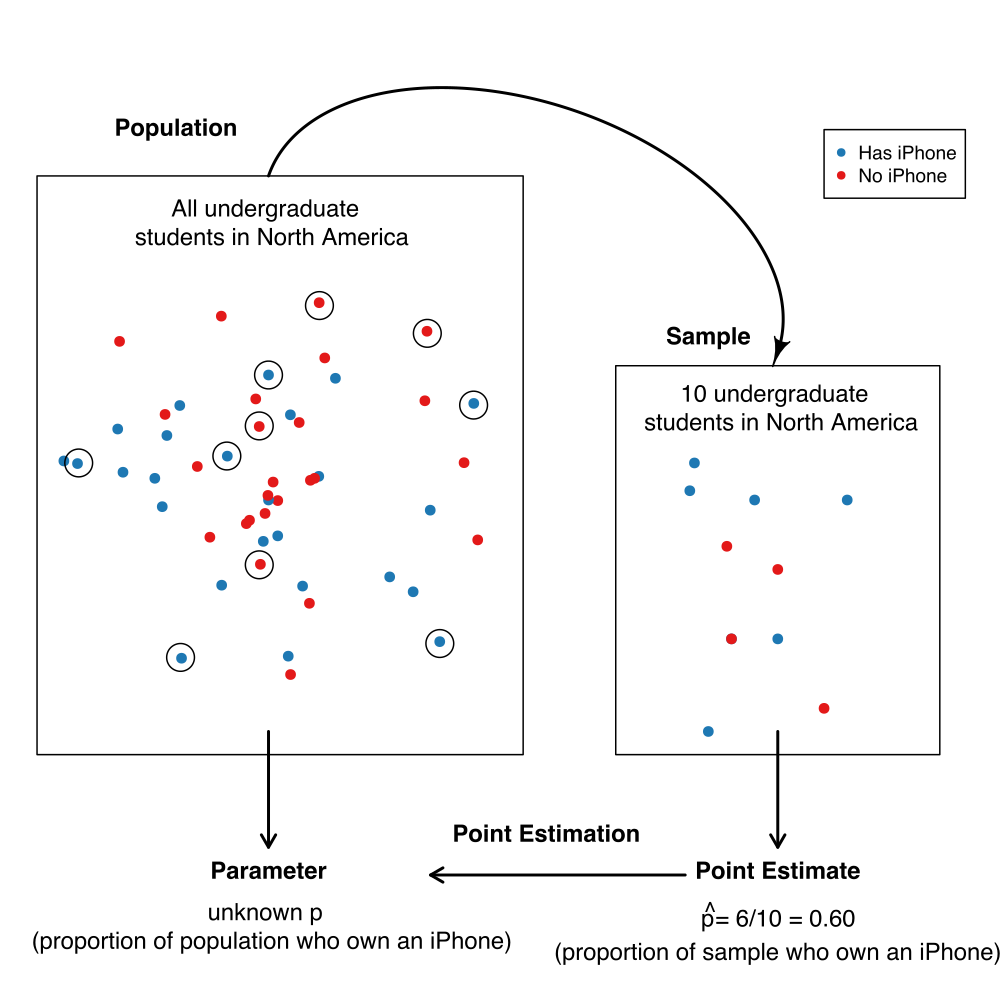!

1. Using categorical observations to estimate the proportion of a category
2. Using quantitative observations to estimate the average (or mean)


### Sampling Distributions - point estimate for proportion



In [ ]:
library(tidyverse)

set.seed(123)

airbnb <- read_csv("data/listings.csv")

# how many Airbnb places are listed as entire homes and apartments
airbnb |>
  summarize(
    n =  sum(room_type == "Entire home/apt"),
    proportion = sum(room_type == "Entire home/apt") / nrow(airbnb)
  )

library(infer)

sample_1 <- rep_sample_n(tbl = airbnb, size = 40) # take a sample of 40 with rep_sample_n

airbnb_sample_1 <- summarize(sample_1,
  n = sum(room_type == "Entire home/apt"),
  prop = sum(room_type == "Entire home/apt") / 40
)

airbnb_sample_1

**sampling variability**
simulate many samples (much more than just two) of size 40 from our population of listings and calculate the proportion of entire home/apartment listings in each sample --> visualize with histogram

**sampling distribution**
The distribution of the estimate for all possible samples of a given size (which we commonly refer to as n) from a population 

In [ ]:
samples <- rep_sample_n(airbnb, size = 40, reps = 20000) # reps --> take 20,000 samples of size 40
samples # replicate = 1
tail(samples) # replicate = 20,000

# obtain 20,000 point estimates (proportion), one for each of the 20,000 samples
sample_estimates <- samples %>%
  group_by(replicate) %>%
  summarize(sample_proportion = sum(room_type == "Entire home/apt") / 40)

sample_estimates
tail(sample_estimates)

In [ ]:
#visualization with histogram

sampling_distribution <- ggplot(sample_estimates, aes(x = sample_proportion)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 12) +
  labs(x = "Sample proportions", y = "Count") +
  theme(text = element_text(size = 12))

sampling_distribution

# calculate mean of hte sample proportions
sample_estimates |>
  summarize(mean = mean(sample_proportion))

In general, the mean of the sampling distribution should be equal to the population proportion.   
If you were to take many samples as we did above, there is no tendency towards over or underestimating the population proportion.   
In a real data analysis setting where you just have access to your single sample, this implies that you would suspect that your sample point estimate is roughly equally likely to be above or below the true population proportion. 

### Sampling distributions - point estimate for means
estimate the population mean (or average) price per night of Airbnb listings

In [ ]:
# visualize population distribution **Note: different from sampling distribution
population_distribution <- ggplot(airbnb, aes(x = price)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
  labs(x = "Price per night (Canadian dollars)", y = "Count") +
  theme(text = element_text(size = 12))

population_distribution

# compute mean of population
population_parameters <- airbnb %>%
  summarize(pop_mean = mean(price))


**point estimate for the mean of the full population**

In [ ]:
#Sampling

one_sample <- airbnb %>%
  rep_sample_n(40)

# visualize sample distribution --> still different from sampling distribution
sample_distribution <- ggplot(one_sample, aes(price)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
  labs(x = "Price per night (Canadian dollars)", y = "Count") +
  theme(text = element_text(size = 12))

sample_distribution

# compute sample mean
estimates <- one_sample %>%
  summarize(sample_mean = mean(price))

In [ ]:
# Sampling distribution
samples <- rep_sample_n(airbnb, size = 40, reps = 20000)

sample_estimates <- samples |>
  group_by(replicate) |>
  summarize(sample_mean = mean(price))

sampling_distribution_40 <- ggplot(sample_estimates, aes(x = sample_mean)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
  labs(x = "Sample mean price per night (Canadian dollars)", y = "Count") +
  theme(text = element_text(size = 12))

sampling_distribution_40

### Comparison of three distributions (population, sample, sampling)

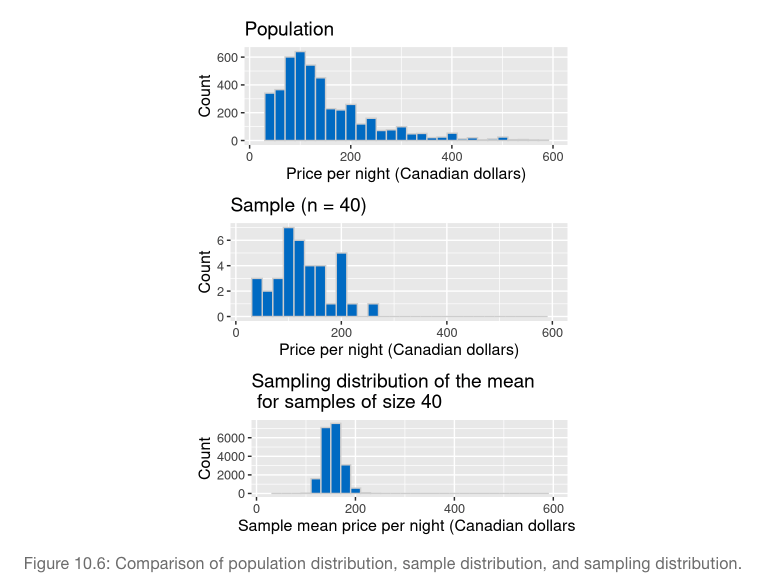

### Improving the sampling estimate
1. take larger sample
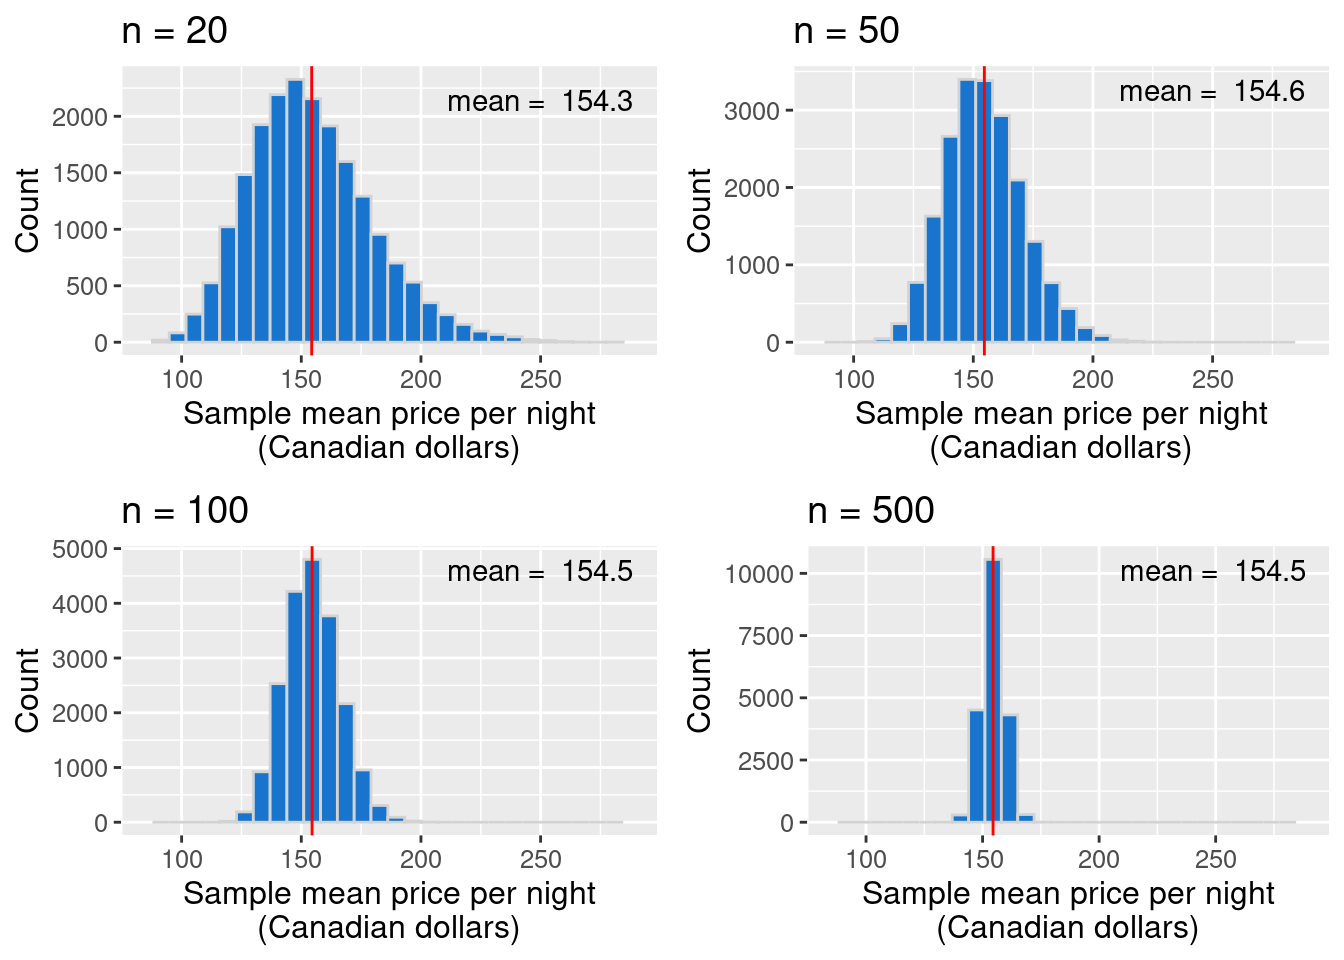  
**Results:**
- mean of the sample mean (across samples) is equal to the population mean - sampling distribution is centered at the population mean
- increasing the size of the sample decreases the spread (i.e., the variability) of the sampling distribution --> narrower histogram --> results in a more reliable point estimate of the population parameter
- distribution of the sample mean is roughly bell-shaped


Note: In general, the sampling distribution—for both means and proportions—only becomes bell-shaped once the sample size is large enough. 
Rule of thumb: often a sample size of at least 20 will suffice.


### Summary
1. A point estimate is a single value computed using a sample from a population (e.g., a mean or proportion).
2. The sampling distribution of an estimate is the distribution of the estimate for all possible samples of a fixed size from the same population.
3. The shape of the sampling distribution is usually bell-shaped with one peak and centered at the population mean or proportion.
4. The spread of the sampling distribution is related to the sample size. As the sample size increases, the spread of the sampling distribution decreases.

## Inference II - Bootstrapping <a name = "inf2"> <a/>

Reporting the point estimate from a single sample alone may not be enough because of sample variability.  
We also need to report some notion of uncertainty in the value of the point estimate.

we could somehow approximate what the sampling distribution would look like for a sample, we could use that approximation to then report how uncertain our sample point estimate is (as we did above with the exact sampling distribution).
bootstrap. We will discuss interval estimation and construct confidence intervals using just a single sample from a population. A confidence interval is a range of plausible values for our population parameter.

First, if you take a big enough sample, it looks like the population. if our sample is big enough that it looks like our population, we can pretend that our sample is the population, and take more samples (with replacement) of the same size from it instead! This very clever technique is called the bootstrap.

Note that by taking many samples from our single, observed sample, we do not obtain the true sampling distribution, but rather an approximation that we call the bootstrap distribution.

We must sample with replacement when using the bootstrap. Otherwise, if we had a sample of size n, and obtained a sample from it of size n without replacement, it would just return our original sample!

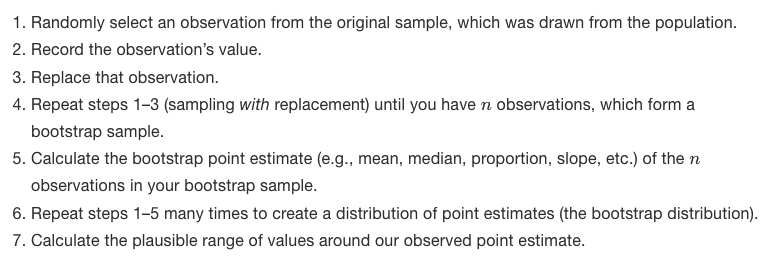

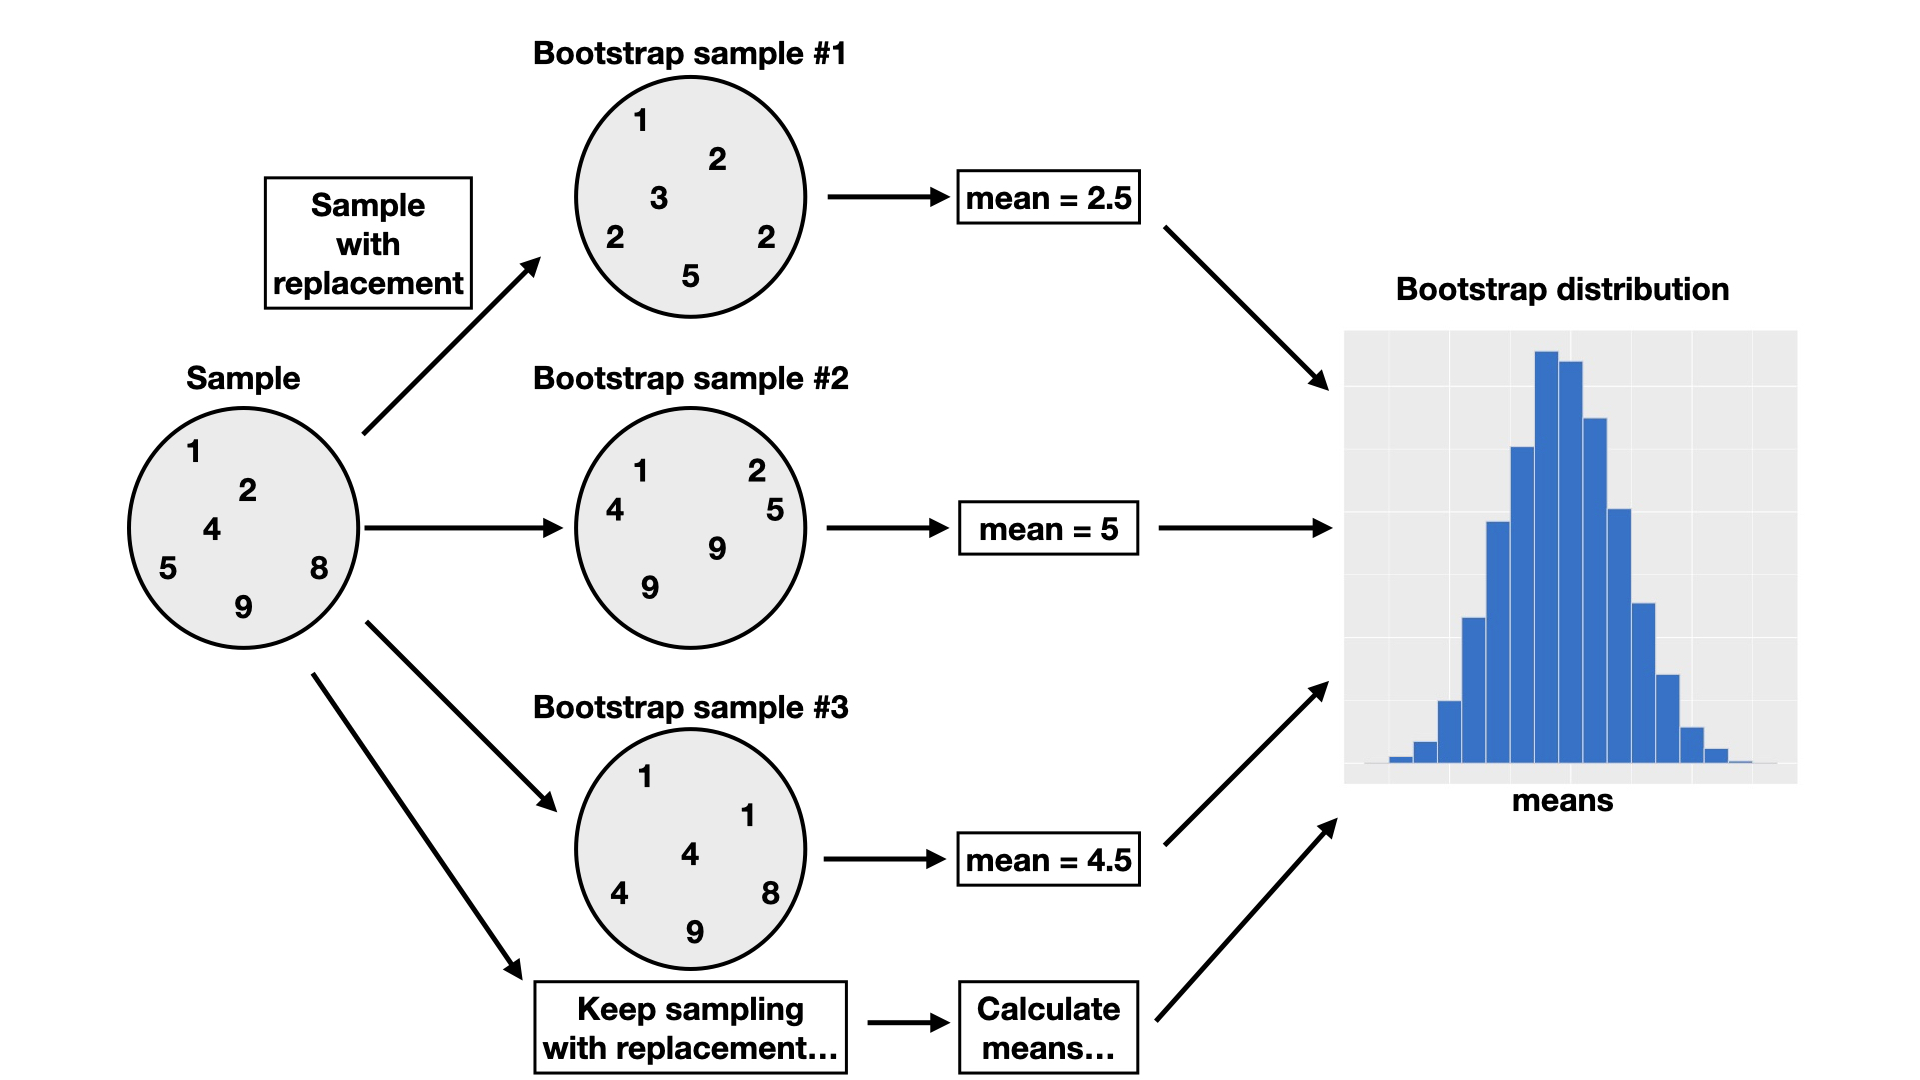

In [ ]:
one_sample
one_sample_dist <- ggplot(one_sample, aes(price)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
  labs(x = "Price per night (Canadian dollars)", y = "Count") +
  theme(text = element_text(size = 12))

one_sample_dist

In [ ]:
boot1 <- one_sample |>
  rep_sample_n(size = 40, replace = TRUE, reps = 1) # sample with replacement

# Bootstrap distribution
boot1_dist <- ggplot(boot1, aes(price)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
  labs(x = "Price per night (Canadian dollars)", y =  "Count") + 
  theme(text = element_text(size = 12))

boot1_dist

In [ ]:
summarize(boot1, mean = mean(price))

this assumes that one_sample looks like our original population; but since we do not have access to the population itself, this is often the best we can do.

In [ ]:
boot20000 <- one_sample |>
  rep_sample_n(size = 40, replace = TRUE, reps = 20000)

boot20000

In [1]:
# take a look at histograms of the first six replicates of our bootstrap samples.
six_bootstrap_samples <- boot20000 |>
  filter(replicate <= 6)

ggplot(six_bootstrap_samples, aes(price)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
  labs(x = "Price per night (Canadian dollars)", y = "Count") +
  facet_wrap(~replicate) +
  theme(text = element_text(size = 12))

#calculate the sample mean 
six_bootstrap_samples |>
  group_by(replicate) |>
  summarize(mean = mean(price))

ERROR: Error in parse(text = x, srcfile = src): <text>:2:37: unexpected '>'
1: # take a look at histograms of the first six replicates of our bootstrap samples.
2: six_bootstrap_samples <- boot20000 |>
                                       ^


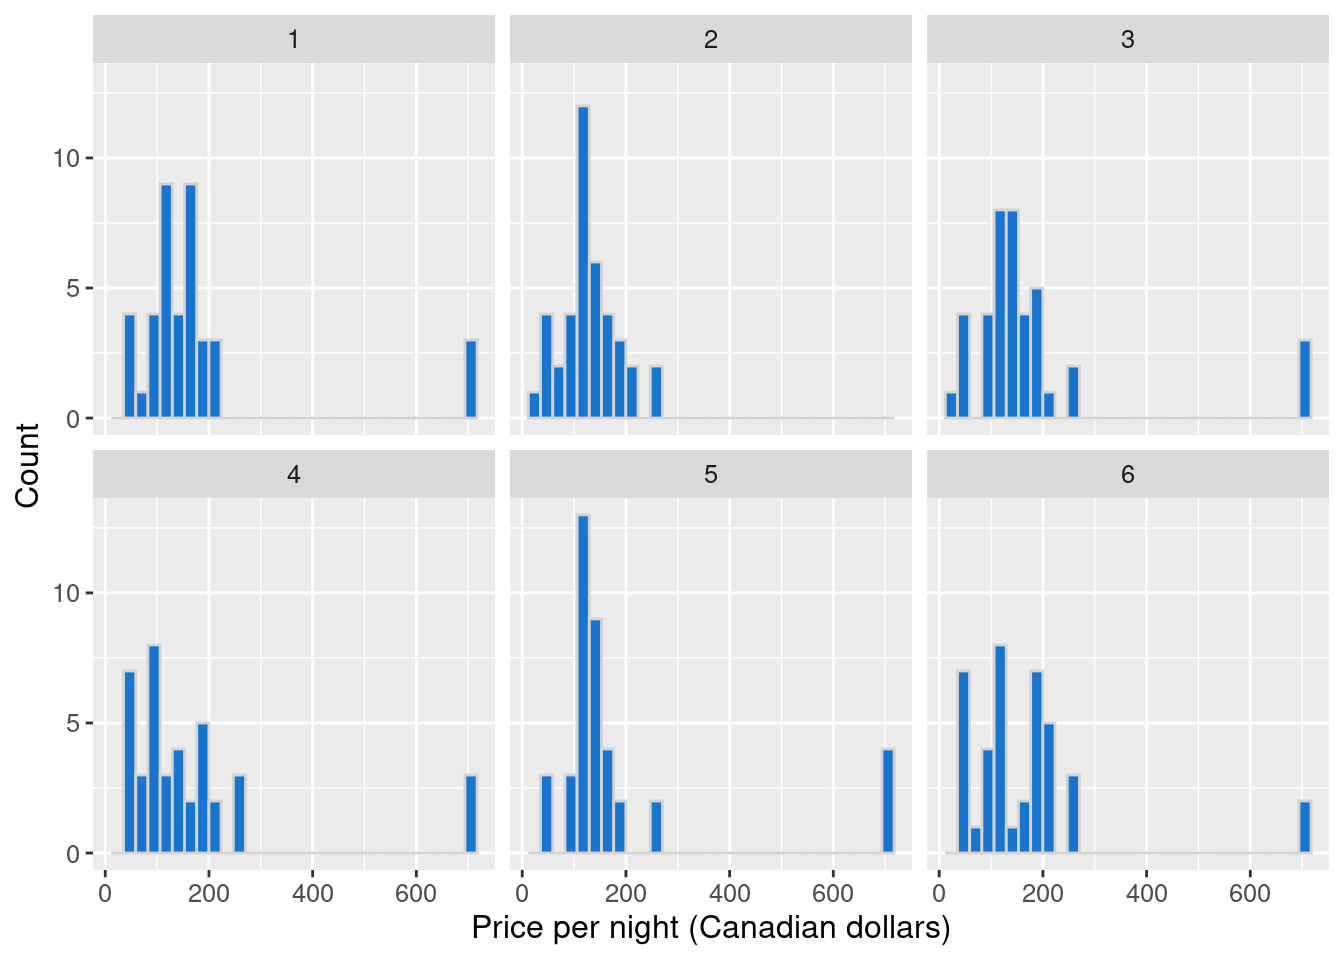

The bootstrap distribution (Figure 10.13) suggests how we might expect our point estimate to behave if we took another sample.

In [ ]:
# bootstrap distribution
boot20000_means <- boot20000 |>
  group_by(replicate) |>
  summarize(mean = mean(price))

boot20000_means

boot_est_dist <- ggplot(boot20000_means, aes(x = mean)) +
  geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
  labs(x = "Sample mean price per night \n (Canadian dollars)", y = "Count") +
  theme(text = element_text(size = 12))

boot_est_dist

### Sampling Distribution vs. Bootstrap Distribution

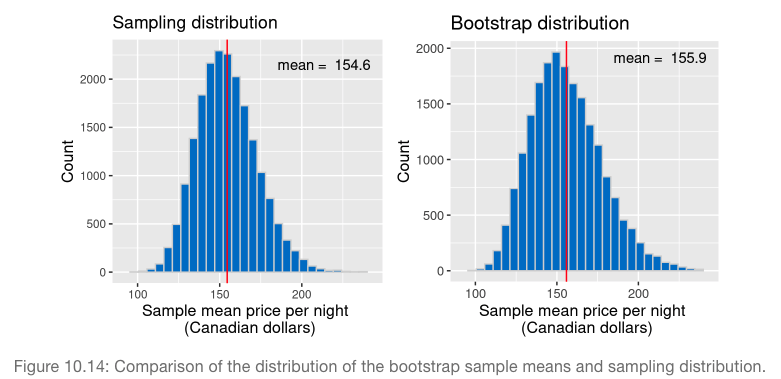

1. the shape and spread of the true sampling distribution and the bootstrap distribution are similar; the bootstrap distribution lets us get a sense of the point estimate’s variability
2. Because we are resampling from the original sample repeatedly, we see that the bootstrap distribution is centered at the original sample’s mean value (unlike the sampling distribution of the sample mean, which is centered at the population parameter value).

### confidence interval
- a range of plausible values for the population parameter
- If we took 100 random samples and calculated 100 95% confidence intervals, then about 95% of the ranges would capture the population parameter’s value. 

**balance between our level of confidence and precision**  
A higher confidence level corresponds to a wider range of the interval, and a lower confidence level corresponds to a narrower range.

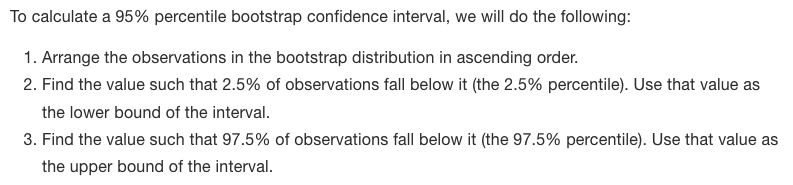

In [ ]:
bounds <- boot20000_means |>
  select(mean) |>
  pull() |>
  quantile(c(0.025, 0.975)) # computes CI

bounds

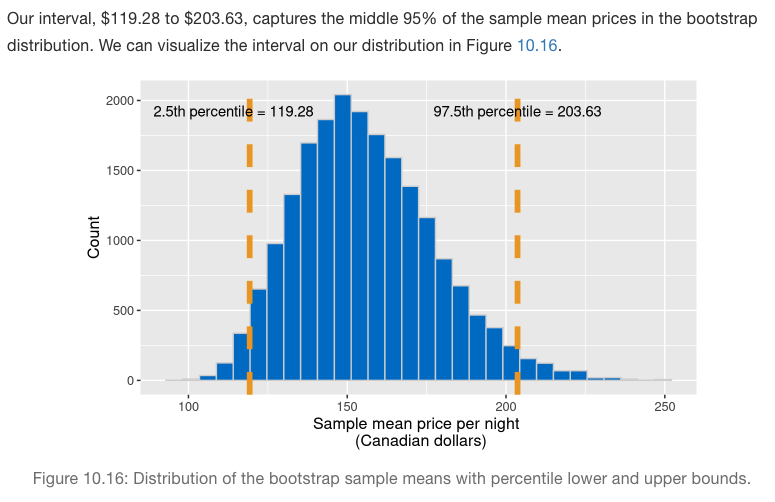

sample mean price-per-night of 40 Airbnb listings was 155.8 dollars and we are 95 percent confident that the true population mean price-per-night for all Airbnb listings in Vancouver is between (119.28, 203.63) dollars.